<a href="https://colab.research.google.com/github/NinelK/IMBIZO2022_DS_tutorial_solutions/blob/main/DS_Tutorial_Part_3_SOLUTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setups

In [1]:
import datetime
import h5py
import jax.numpy as jnp
from jax.scipy.linalg import inv
from jax import random
from jax.experimental import optimizers
from jax.config import config
from jax.nn import relu
from jax.random import poisson as jpoisson
#config.update("jax_debug_nans", True) # Useful for finding numerical errors
import matplotlib.pyplot as plt
import numpy as np  # original CPU-backed NumPy
import os
import sys
from importlib import reload
from tqdm import tqdm
import time

from sklearn.decomposition import PCA
start = time.time()

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [2]:
%%capture
! git clone -b SA_tutorial https://github.com/NinelK/jax-lfads.git
# ! rm -r /content/jax-lfads/

In [3]:
# You must change this to the location of the computation-thru-dynamics directory.
HOME_DIR = '/content'  # if running locally -- change this to YOUR path to the folder containing this notebook

sys.path.append(os.path.join(HOME_DIR,'jax-lfads'))
import lfads_tutorial.lfads as lfads
import lfads_tutorial.utils as utils
from lfads_tutorial.optimize import optimize_lfads, get_kl_warmup_fun

In [4]:
# Make directories
lfads_dir = os.path.join(HOME_DIR,'lfads')       # where to save lfads data and parameters to
output_dir = os.path.join(lfads_dir, 'output/')
figure_dir = os.path.join(lfads_dir, os.path.join(output_dir, 'figures/'))
if not os.path.exists(lfads_dir):
    os.makedirs(output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

# Part 3: Recurrent neural networks (RNNs) as dynamical systems

### Vanilla RNN


Let us first consider the simplest, yet most important example of a non-linear discrete-time latent dynamical system: a **recurrent neural network**. It is a go-to tool for modelling sequences in deep learning.

Latent dynamics: $$h_{t} = \sigma (V h_{t-1} + U x_t + b_h)$$
Emission model: $$o_t = W h_t + b_o $$


![RNN scheme (Wiki)](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/2560px-Recurrent_neural_network_unfold.svg.png)


Similarly to the multi-layer networks that you have seen in a previous tutorial, RNNs can be trained through backpropagation. Although, instead of propagating gradients through layers, here we would propagate gradients throught **time**. To see how this can be done, we need to unfold timesteps into a sequence (right plot above). In these unfolded scheme, each column is a 2-layer perceptron. The new thing is a transition from the previous time step to the next. This is called backpropagation through time (BPTT).

#### Exercise 1: Implement a Vanilla RNN

In [5]:
def vanilla_rnn_params(key, n, u, ifactor=1.0, hfactor=1., hscale=0.0):
  """Initialize Vanilla RNN parameters for LFADS

  Arguments:
    key: random.PRNGKey for random bits
    n: hidden state size
    u: input size
    ifactor: scaling factor for input weights
    hfactor: scaling factor for hidden -> hidden weights
    hscale: scale on h0 initial condition

  Returns:
    a dictionary of parameters
  """
  key, skeys = utils.keygen(key, 3)
  ifactor = ifactor / jnp.sqrt(u)
  hfactor = hfactor / jnp.sqrt(n)

  h0 = random.normal(next(skeys), (n,)) * hscale
  wA = random.normal(next(skeys), (n,n)) * hfactor
  wB = random.normal(next(skeys), (n,u)) * ifactor
  wb = jnp.zeros((n,))

  return {'h0' : h0,
          'wA' : wA,
          'wB' : wB,
          'wb' : wb}


def vanilla_rnn(params, h, x, nonlin=jnp.tanh):
  """Implement the Vanilla RNN equations.

  Arguments:
    params: dictionary of RNN parameters
    h: np array of hidden state components
    x: np array of input components

  Returns:
    np array of hidden state after RNN update"""
  h_new = nonlin(jnp.dot(params['wA'], h) + jnp.dot(params['wB'], x) + params['wb']) #2remove
  return h_new


## RNN-based generative models of neuronal population dynamics

RNNs are used in neuroscience for various purposes: 
* as a normative model trained to perform a certain task (a task-trained RNN);
* as an ML blackbox tool for behavioral seq2seq decoding (inputs: neural spike trains, outputs: behavior).
* as a model of neural population activity.

We will focus on population models in this tutorial.

In general, fitting an RNN to data allows one to speculate about the *computation* that the neural population is performing.
However, there are multiple options for describing neuronal populations with RNNs, which can be divided into 2 large groups [3]: 
1. **Fully-observed models:** In these models, RNN units (components of vector $\mathbf{h}$) would have 1-to-1 correspondence to single neural firing rates, while outputs $\mathbf{o}$ can correspond to some behavioral outputs (e.g. hand position in space).
2. **Latent dynamics models:** in these models neural firing rates would correspond to the outputs $\mathbf{o}$, while $\mathbf{h}$ (latent state) would summarize what a neuronal population as a whole is doing.

![two model types](https://drive.google.com/uc?export=view&id=16G4HWvarW8rtNlBSlnCvCIcJq78Pr7Lu)

In this tutorial, we will focus on the second class of models: the models of latent dynamics. 

These models are useful for understanding modern single-unit recordings, which can have 100-1000-10000 of recorded neurons simultaneously. We can't visualize or analyse such high-dimensional data!
At the same time, it was shown that neural population activity often has a low-dimensional structure: a low number of latent dynamical factors can explain a large fraction of neural variability. This finding is called a 'manifold hypothesis', and was proposed in [Vyas et al. 2020](#references).



## Forward problem: generating data from a latent dynamics model

#### Exercise 2: Generate some spike data from a VRNN

Suppose a neural population with $N$ neurons follows a simple dynamics. Let's imagine that it oscillates. We can describe this dynamics with 2 latent factors, similarly to a pendulum in Tutorial Part 1.

$${\begin{bmatrix}
    \dot h_1 \\
    \dot h_2
\end{bmatrix}} = \begin{bmatrix}
    0 & 1 \\
    -1 & 0
\end{bmatrix} \begin{bmatrix}
    h_1 \\
    h_2
\end{bmatrix} \tag{2a}$$

Now, suppose log-firing rate of each neuron in a population is a sum of these two factors with some arbitrarily chosen coefficients:

$${\begin{bmatrix}
    \log r_1 \\
    \log r_2 \\
    \ldots \\
    \log r_N
\end{bmatrix}} = {\begin{bmatrix}
    o_1 \\
    o_2 \\
    \ldots \\
    o_N
\end{bmatrix}} = \underbrace{B}_{N \times 2} \begin{bmatrix}
    h_1 \\
    h_2
\end{bmatrix} + {\begin{bmatrix}
    b_1 \\
    b_2 \\
    \ldots \\
    b_N
\end{bmatrix}} \tag{2b}$$

$$\mathrm{spikes}_i \sim \mathrm{Poisson}(r_i) \tag{2c}$$

The equations above constitute a so-called "generative model". 

Let us implement this model and run in a *forward* mode to generate some spikes:

In [6]:
def emission_model(params, h, key):
  key, skeys = utils.keygen(key, 1)
  o = jnp.dot(params['wW'],h) + params['wbo']
  s = jpoisson(next(skeys), jnp.exp(o))
  return s

def generative_model(params, h, x, skeys):
  h = vanilla_rnn(params, h, x, nonlin=lambda x: x)
  s = emission_model(params, h, skeys)
  return h, s

n,N = 2, 100
key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
w = .2
params = {'wA' : jnp.array([[np.sqrt(1.-w**2),w],[-w,np.sqrt(1.-w**2)]]),
          'wB' : jnp.zeros((2,2)),
          'wb' : jnp.zeros((n,)),
          'wW' : random.normal(key, (N,n)),
          'wbo': jnp.zeros((N,))}
T = 50
num_trials = 200
synth_spikes = []
ic_angle = []
for _ in tqdm(range(num_trials)):
  a = np.random.uniform() *2 * jnp.pi - jnp.pi
  h = jnp.array([np.sin(a),np.cos(a)]).flatten()
  spikes_this_trial = []
  for t in range(T):
    key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
    h, s = generative_model(params, h, jnp.zeros((n,)), key)
    spikes_this_trial.append(s)
  synth_spikes.append(spikes_this_trial)
  ic_angle.append(a)

100%|██████████| 200/200 [01:07<00:00,  2.97it/s]


## Inverse problem: inferring dynamics & initial conditions using LFADS

We have generated some spike trains, for which we know the uderlying DS (the initial conditions and true underlying dynamics). In real experiments, the true dynamics and initial conditions are NOT known, but it would be useful to find the *most likely* DS that could have produced these spikes. Once we have this DS, we can analyse it and describe what this DS is doing like in Tutorial Parts 1-2.

<!-- Assuming the generative model as in (2b-2c) and some spikes recorded from real neuronal population, one may ask: what was the most probable initial conditions & dynamics that generated this data? -->


This inverse problem is not an easy machine learning problem. It involves many concepts, such as Bayesian statistics, that you will study later during the school. Here, we won't go into details and will use one of the existing solutions: an LFADS framework.

**LFADS** stands for Latent Factor Analysis via Dynamical Systems [Pandarinath et al. 2018](#references). It takes in a sequence of spikes in a format: \[trials x time x neurons\]. LFADS is a auto-encoder: it **encodes** spike sequences into initial conditions, and then **decodes** firing rates from these initial conditions using a dynamical generative model:  

![autonomous_LFADS](https://drive.google.com/uc?export=view&id=1lz3sL5NAbWLaQl0yZ8nLcyD4JgHCwGns)

As an auto-encoder, LFADS implements an information bottleneck: it gets rid of all unimportant variations in the data, but keeps the meaningful information in initial conditions. 
*More precisely, LFADS is a variational auto-encoder (VAE), which means that the bottleneck is achieved via probabilistic methods [0]*. The initial conditions are encoded in a distribution: a normal distribution $q_\Theta(g_{0,j} | \mathrm{spikes}) \sim \mathcal{N}(\mu_j,\sigma_j)$ (where $j$ is a dimension in the latent space). 
This distribution, calculated per-trial, is called an 'approximate posterior'. 

This 'generative' model tells us how *likely* it is that the recorded spikes were produced by a dynamical model (2a-2c) and initial conditions $h_0$ ($g_0$ in LFADS paper). So, the loss function we are going to optimize is:

$$\mathcal{L}(\Theta) = \underbrace{- \left < \sum_{t=0}^T \log p_\Theta (\mathrm{\mathbf{spikes}}_t | \mathbf{r}_t) \right >_{\mathbf{g_0}}}_{LL} + \mathrm{penalties} \tag{3}$$
where $\mathrm{\mathbf{spikes}}_t$ and $\mathbf{r}_t$ are vectors of size $N$, where $N$ is a number of neurons. The likelihood $p_\Theta (\mathrm{\mathbf{spikes}}_t | \mathbf{r}_t)$ corresponds to the Poisson likelihood and tells how likely it is that neural population produced a certain number of spikes ($\mathrm{\mathbf{spikes}}_t$) in a time bin $t$, *given* the firing rate $\mathbf{r}_t$. This likelihood is then averaged ($<.>$) across the samples from the posterior distribution of $\mathbf{g}_0$. $\Theta$ here corresponds to all 'trainable' parameters in an LFADS model: the parameters we are going to optimize to minimize the loss $\mathcal{L}(\Theta)$.

LFADS is a statistical model. We will use some data ('training set') to train the model: optimize its parameters $\Theta$ such that the loss $\mathcal{L}$ (3) is minimal. There is always a risk that such model memorizes the training examples and can not make predictions on some new, unseen examples ('evaluation set').
This is called **overfitting**. To prevent overfitting, we are adding penalties to the loss (3), which force the model to be as simple as possible.

LFADS has 2 types of penalties:

$$\mathcal{L}(\Theta) = \underbrace{- \left < \sum_{t=0}^T \log p_\Theta (\mathrm{\mathbf{spikes}}_t | \mathbf{r}_t) \right >_{\mathbf{g_0}}}_{LL} + \left < D_{KL}(q_\theta (\mathbf{g}_0 | \mathrm{spikes})~||~p(\mathbf{g}_0))\right >_{\mathbf{g_0}} + L2(\Theta) \tag{4}$$

🤯 **If you don't understand these penalties now -- it is ok! It will all makes sense ones you learned Bayesian statistics in the following weeks. For now, assume that penalties keep the model simple.**

The KL-divergence term $D_{KL}$ keeps the initial conditions as uninformative as possible (i.e. keeps the approximate posterior as close to the prior as possible). It limits the amount of 'discriminative information' that can pass through the bottleneck and allows the model to discriminate trials from each other, preventing the model from learning trial identities as a lookup table. L2 term tries to keep all the trainable weights as small as possible.

To formally check whether the model overfits, we need to provide the model with new, unseen examples and check the log-likelihood (LL in (3)) on the evaluation set. Let us then split all available data into train and evaluation sets and leave the evaluation set aside for now:

In [7]:
# convert synthetic data to numpy arrays
data_bxtxn = np.array(synth_spikes)
ic_angle = np.array(ic_angle).flatten()

train_fraction = 0.9     # Train with 90% of the synthetic data, evaluate on 10%
nexamples, ntimesteps, data_dim = data_bxtxn.shape # get the shape of all data

train_data, eval_data = utils.split_data(data_bxtxn,
                                         train_fraction=train_fraction) # split
eval_data_offset = int(train_fraction * data_bxtxn.shape[0])

print(f'First {eval_data_offset} out of {nexamples} trials will be used in training.')


First 180 out of 200 trials will be used in training.


### Set LFADS Parameters (you can ignore them)

In [29]:
# LFADS Hyper parameters
data_dim = train_data.shape[2]  # input to lfads should have dimensions:
ntimesteps = train_data.shape[1] #   (batch_size x ntimesteps x data_dim)
batch_size = 200      # batch size during optimization

# LFADS architecture - The size of the numbers is rather arbitrary, 
# but relatively small because we know the integrator RNN isn't too high 
# dimensional in its activity.
enc_dim = 2         # encoder dim
con_dim = 0          # controller dim
ii_dim = 0           # inferred input dim
gen_dim = 2         # generator dim, should be large enough
factors_dim = gen_dim      # factors dim, should be large enough to capture most variance of dynamics

# Numerical stability
var_min = 0.001 # Minimal variance any gaussian can become.

# Optimization HPs that percolates into model
l2reg = 0.00002

# Initial state prior parameters
# the mean is set to zero in the code
ic_prior_var = 0.1 # this is $\sigma^2_p$ in above paragraph

# Inferred input autoregressive prior parameters
ar_mean = 0.0                 # process mean
ar_autocorrelation_tau = 1.0  # seconds, how correlated each time point is, related to $\phi$ above.
ar_noise_variance = 0.1       # noise variance

lfads_hps = {'data_dim' : data_dim, 'ntimesteps' : ntimesteps,
             'enc_dim' : enc_dim, 'con_dim' : con_dim, 'var_min' : var_min,
             'ic_prior_var' : ic_prior_var, 'ar_mean' : ar_mean,
             'ar_autocorrelation_tau' : ar_autocorrelation_tau,
             'ar_noise_variance' : ar_noise_variance,
             'ii_dim' : ii_dim, 'gen_dim' : gen_dim,
             'factors_dim' : factors_dim,
             'l2reg' : l2reg,
             'batch_size' : batch_size}

num_batches = 3000         # how many batches do we train
print_every = 100            # give information every so often

# Learning rate HPs
step_size = 0.01            # initial learning rate
decay_factor = 0.9998       # learning rate decay param
decay_steps = 1             # learning rate decay param

# Regularization HPs
keep_rate = 0.95             # dropout keep rate during training

# Numerical stability HPs
max_grad_norm = 10.0        # gradient clipping above this value

# The fact that the start and end values are required to be floats is something I need to fix.
kl_warmup_start = 0.0 # batch number to start KL warm-up, explicitly float
kl_warmup_end = 1000.0  # batch number to be finished with KL warm-up, explicitly float
kl_min = .1 # The minimum KL value, non-zero to make sure KL doesn't grow crazy before kicking in.
kl_max = 1.

lfads_opt_hps = {'num_batches' : num_batches, 'step_size' : step_size,
                 'decay_steps' : decay_steps, 'decay_factor' : decay_factor,
                 'kl_min' : kl_min, 'kl_max' : kl_max, 'kl_warmup_start' : kl_warmup_start,
                 'kl_warmup_end' : kl_warmup_end, 'keep_rate' : keep_rate,
                 'max_grad_norm' : max_grad_norm, 'print_every' : print_every,
                 'adam_b1' : 0.9, 'adam_b2' : 0.999, 'adam_eps' : 1e-4}

class hashabledict(dict):
    def __hash__(self):
        return hash(tuple(sorted(self.items())))

lfads_hps = hashabledict(lfads_hps)
lfads_opt_hps = hashabledict(lfads_opt_hps)

assert num_batches >= print_every and num_batches % print_every == 0

### Initialize LFADS

In [30]:
# Initialize parameters for LFADS
from functools import partial

# setting up the generator model
rnn_type = 'vanilla_rnn'
nonlin = lambda x: jnp.tanh(x) # specify a nonlinearity
model = partial(vanilla_rnn, **{'nonlin': nonlin})
model_params = vanilla_rnn_params
  
key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
init_params = lfads.lfads_params(key, lfads_hps, gen_rnn_params=model_params)

### Train LFADS

In [31]:
# Takes 3 minutes to train on a GPU; first step takes ~13 sec.
# roughly the same time on a CPU, because the model is small
key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
trained_params, opt_details = \
    optimize_lfads(key, init_params, lfads_hps, lfads_opt_hps,\
                   train_data, eval_data, gen=model)

Batches 1-100 in 12.87 sec, Step size: 0.00980
    Training losses 3800 = NLL 3800 + KL IC 3,0 + KL II 0,0 + L2 0.00
        Eval losses 3767 = NLL 3766 + KL IC 3,0 + KL II 0,0 + L2 0.00
Batches 101-200 in 1.99 sec, Step size: 0.00961
    Training losses 3753 = NLL 3752 + KL IC 4,1 + KL II 0,0 + L2 0.00
        Eval losses 3771 = NLL 3770 + KL IC 4,1 + KL II 0,0 + L2 0.00
Batches 201-300 in 2.05 sec, Step size: 0.00942
    Training losses 3740 = NLL 3739 + KL IC 4,1 + KL II 0,0 + L2 0.00
        Eval losses 3719 = NLL 3718 + KL IC 4,1 + KL II 0,0 + L2 0.00
Batches 301-400 in 2.16 sec, Step size: 0.00923
    Training losses 3741 = NLL 3739 + KL IC 3,1 + KL II 0,0 + L2 0.00
        Eval losses 3704 = NLL 3703 + KL IC 3,1 + KL II 0,0 + L2 0.00
Batches 401-500 in 1.96 sec, Step size: 0.00905
    Training losses 3497 = NLL 3496 + KL IC 3,1 + KL II 0,0 + L2 0.00
        Eval losses 3527 = NLL 3525 + KL IC 3,1 + KL II 0,0 + L2 0.00
Batches 501-600 in 1.97 sec, Step size: 0.00887
    Training 

In [32]:
# saving model parameters of the trained model
fname_uniquifier = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
network_fname = (f'trained_params_lfads_pend_{rnn_type}' + fname_uniquifier + '.npz')
network_path = os.path.join(output_dir, network_fname)

print("Saving parameters: ", network_path)
np.savez(network_path, trained_params)


Saving parameters:  /content/lfads/output/trained_params_lfads_pend_vanilla_rnn2022-08-13_14:56:13.npz


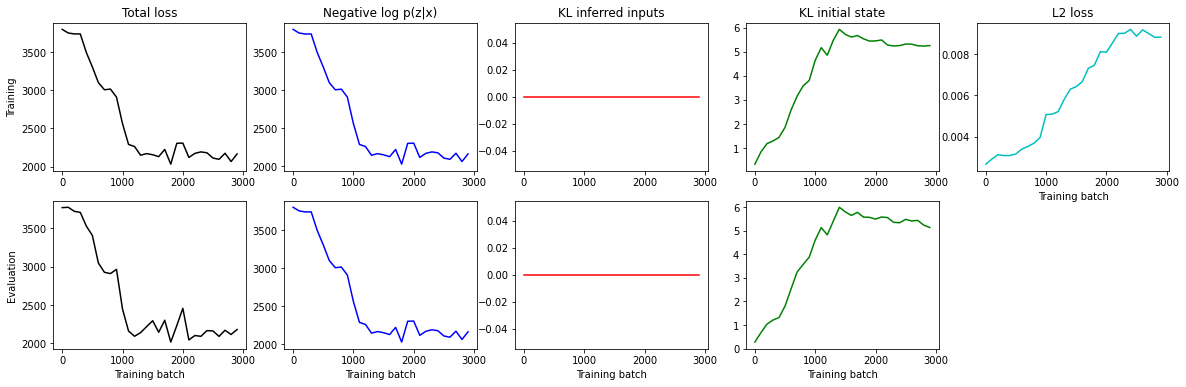

In [33]:
# Plot the training details
x = np.arange(0, num_batches, print_every)
plt.figure(figsize=(20,6))
plt.subplot(251)
plt.plot(x, opt_details['tlosses']['total'], 'k')
plt.ylabel('Training')
plt.title('Total loss')
plt.subplot(252)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.title('Negative log p(z|x)')
plt.subplot(253)
plt.plot(x, opt_details['tlosses']['kl_ii'], 'r')
plt.title('KL inferred inputs')
plt.subplot(254)
plt.plot(x, opt_details['tlosses']['kl_g0'], 'g')
plt.title('KL initial state')
plt.subplot(255)
plt.plot(x, opt_details['tlosses']['l2'], 'c')
plt.xlabel('Training batch')
plt.title('L2 loss')
plt.subplot(256)
plt.plot(x, opt_details['elosses']['total'], 'k')
plt.xlabel('Training batch')
plt.ylabel('Evaluation')
plt.subplot(257)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.xlabel('Training batch')
plt.subplot(258)
plt.plot(x, opt_details['elosses']['kl_ii'], 'r')
plt.xlabel('Training batch')
plt.subplot(259)
plt.plot(x, opt_details['elosses']['kl_g0'], 'g')
plt.xlabel('Training batch');

### Visualize latent space trajectories

In [34]:
# Plot a bunch of examples of eval trials run through LFADS.

bidx = 0

nexamples_to_save = 1
for eidx in range(nexamples_to_save):
    fkey = random.fold_in(key, eidx)
    psa_example = eval_data[bidx,:,:].astype(jnp.float32)
    psa_dict = lfads.posterior_sample_and_average_jit(trained_params, lfads_hps, 
                                                      fkey, psa_example, gen=model)


dict_keys(['c_t', 'factor_t', 'gen_t', 'ic_logvar', 'ic_mean', 'ii_logvar_t', 'ii_mean_t', 'ii_t', 'lograte_t', 'xenc_t'])

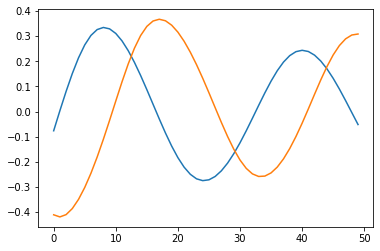

In [35]:
# plt.plot(psa_dict['factor_t'])
plt.plot(psa_dict['factor_t'])
psa_dict.keys()

In [36]:
# sample trajectories
ics = np.empty((data_bxtxn.shape[0],gen_dim))
gen_traj = np.empty((data_bxtxn.shape[0],ntimesteps,gen_dim))
for i, psa_example in enumerate(data_bxtxn.astype(jnp.float32)):
    psa_dict = lfads.posterior_sample_and_average_jit(trained_params, lfads_hps, 
                                                      fkey, psa_example, gen=model)
    ics[i] = psa_dict['ic_mean']
    gen_traj[i] = psa_dict['gen_t']

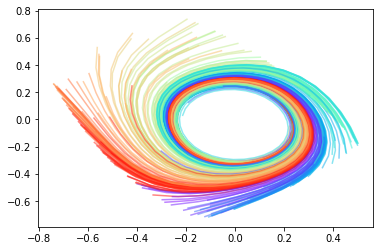

In [37]:
for a,t in zip(ic_angle,gen_traj):
  plt.plot(*t.T, c=plt.cm.rainbow(a / (2*np.pi) + 0.5),alpha=0.5)

### Fixed point analysis

### Exercise 3: Linearizing around the fixed point: calculating the Jacobian

In [38]:
%load_ext autoreload
%autoreload 2
import fixed_point_finder.fixed_points as fp_optimize
from jax import vmap
import gc

gc.collect() # free up some RAM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


20126

In [39]:
# These are some preliminaries. 
x_star = np.zeros(ii_dim)  # the input is zero in this example.

# Make a one parameter function of thie hidden state, useful for jacobians.
key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
# params = hashabledict(model_params(key, gen_dim, ii_dim))
rnn_fun = lambda h : model(trained_params['gen'], h, x_star)
batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))


Create some functions that define the fixed point loss
which is just the squared error of a point for a discrete time system such as a VRNN or GRU: $(h_{n+1} - h_n)^2$

In [40]:
fp_loss_fun = fp_optimize.get_fp_loss_fun(rnn_fun)
total_fp_loss_fun = fp_optimize.get_total_fp_loss_fun(rnn_fun)

We have to start the fixed point finder with some points, and it's always best to start with examples of where the state normally operates.


In [41]:
fp_candidates = jnp.array(gen_traj[::50,])                 # was batch x time x dim
fp_candidates = jnp.reshape(fp_candidates, (-1, gen_dim))  # now (batch * time) x dim

In [42]:
# Fixed point optimization hyperparameters
fp_num_batches = 1000         # Total number of batches to train on.
fp_batch_size = 100          # How many examples in each batch
fp_step_size = 0.2          # initial learning rate
fp_decay_factor = 0.9999     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5
fp_opt_print_every = 200   # Print training information during optimziation every so often

# Fixed point finding thresholds and other HPs
fp_noise_var = 0.0      # Gaussian noise added to fixed point candidates before optimization.
fp_opt_stop_tol = 0.00001  # Stop optimizing when the average value of the batch is below this value.
fp_tol = 0.00001        # Discard fps with squared speed larger than this value.
fp_unique_tol = 0.025      # tolerance for determination of identical fixed points
fp_outlier_tol = 1.0    # Anypoint whos closest fixed point is greater than tol is an outlier.


In [43]:
fp_candidates.shape

(200, 2)

Trained RNNs rarely have 'true' fixed points. More often, they have 'slow points': the points where the state **almost** does not change. 

#### **Think!**

Will we approximate all types of fixed points with the 'slow points' approximation?

**Answer:** No. We can only catch attractors this way.

In [44]:
reload(fp_optimize)

fp_hps = {'num_batches' : fp_num_batches, 'step_size' : fp_step_size, 
            'decay_factor' : fp_decay_factor, 'decay_steps' : fp_decay_steps, 
            'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2,
            'adam_eps' : fp_adam_eps, 'noise_var' : fp_noise_var, 
            'fp_opt_stop_tol' : fp_opt_stop_tol, 'fp_tol' : fp_tol, 
            'unique_tol' : fp_unique_tol, 'outlier_tol' : fp_outlier_tol, 
            'opt_print_every' : fp_opt_print_every}

fp_hps = hashabledict(fp_hps)

fps, fp_losses, fp_idxs, fp_opt_details = \
  fp_optimize.find_fixed_points(rnn_fun, fp_candidates, fp_hps, do_print=True)
if len(fp_idxs) > 0:
    F_of_fps = batch_rnn_fun(fps)
else:
    F_of_fps = np.zeros([0,gen_dim])
    
fps = {'fps' : fps, 'candidates' : fp_candidates[fp_idxs],
                'losses' : fp_losses, 'F_of_fps' : F_of_fps, 
                'opt_details' : fp_opt_details, 'hps' : fp_hps}

fps


Optimizing to find fixed points.
    Batches 1-200 in 0.20 sec, Step size: 0.19604, Training loss 0.00000
Stopping as mean training loss 0.00000 is below tolerance 0.00001.
Excluding fixed points with squared speed above tolerance 0.00001.
    Kept 200/200 fixed points with tolerance under 0.000010.
Excluding non-unique fixed points.
    Kept 1/200 unique fixed points with uniqueness tolerance 0.025000.
Excluding outliers.
Sorting fixed points slowest first.


{'F_of_fps': DeviceArray([[ 0.00627206, -0.03576707]], dtype=float32),
 'candidates': DeviceArray([[-0.333722 , -0.5555686]], dtype=float32),
 'fps': DeviceArray([[ 0.00627266, -0.03576656]], dtype=float32),
 'hps': {'adam_b1': 0.9,
  'adam_b2': 0.999,
  'adam_eps': 1e-05,
  'decay_factor': 0.9999,
  'decay_steps': 1,
  'fp_opt_stop_tol': 1e-05,
  'fp_tol': 1e-05,
  'noise_var': 0.0,
  'num_batches': 1000,
  'opt_print_every': 200,
  'outlier_tol': 1.0,
  'step_size': 0.2,
  'unique_tol': 0.025},
 'losses': array([3.098845e-13], dtype=float32),
 'opt_details': {'fp_losses': [DeviceArray(4.821553e-13, dtype=float32)]}}

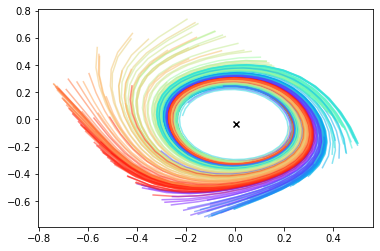

In [45]:
for a,t in zip(ic_angle,gen_traj):
  plt.plot(*t.T, c=plt.cm.rainbow(a / (2*np.pi) + 0.5),alpha=0.5)
assert len(fps['fps']) == 1, 'That\'s strange! The cell above found more than one point'
plt.scatter(*fps['fps'][0],marker='x',c='k')

You should see one fixed point in the center of rotation. Looks good so far!

Now because we use JAX already, we can compute the Jacobian $J = \partial(h_{n+1})/\partial(h_{n})$ using built-in automatic differentiation:

In [46]:
jacs = fp_optimize.compute_jacobians(rnn_fun, fps['fps'])
J = jacs[0] # still assuming just 1 fixed point
print('Jacobian:\n',J)

Jacobian:
 [[ 0.97382146 -0.17076857]
 [ 0.23832107  1.0133729 ]]


Now our non-linear dynamical system is approximated as $h_{n+1} \approx J h_n$. It is a linear system! 

Let us just the eigendecomposition for it:

In [47]:
np.linalg.eig(J) # 2remove

(array([0.99359715+0.2007652j, 0.99359715-0.2007652j], dtype=complex64),
 array([[-0.06333471+0.6429808j, -0.06333471-0.6429808j],
        [ 0.76325905+0.j       ,  0.76325905-0.j       ]], dtype=complex64))

What is this system doing? Is the fixed point stable? What is the frequency of oscillations? 

### Extra exercise 4: How is the Jacobian different from the learned matrix $A$? Why?

In [48]:
A = trained_params['gen']['wA'] # 2remove
A

DeviceArray([[ 0.9738598 , -0.1707753 ],
             [ 0.23862635,  1.014671  ]], dtype=float32)

In [49]:
end = time.time()

(end-start)/60

7.490020028750101

# **Project:** Modelling dynamics based on REAL data

The next notebook is doing the same things as this one, but with REAL neural recordings. 

[Go to the next notebook](https://colab.research.google.com/drive/1CM6GLsDdUpaXcAnjjiLQGtUJZe5GH7MM?usp=sharing)

# References
<a name="references"></a>
0. [Computation through dynamics tutorial](https://github.com/google-research/computation-thru-dynamics) from David Sussillo, which contains an implementation of LFADS that was adapted to this tutorial + extra material (in depth LFADS tutorial, inferring unobserved inputs, FORCE training)

1. *Manifold hypothesis:* Gallego, Juan A., et al. "Neural manifolds for the control of movement." Neuron 94.5 (2017): 978-984.

2. *A review of a population dynamics models:* Vyas, Saurabh, et al. "Computation through neural population dynamics." Annual Review of Neuroscience 43 (2020): 249. [Not paywalled pdf.](https://web.stanford.edu/~mgolub/publications/2020-Vyas-ARN.pdf)

3. *Our review on fully observed vs latent dynamical models*: Hurwitz, Cole, et al. [Building population models for large-scale neural recordings: Opportunities and pitfalls.](https://arxiv.org/pdf/2102.01807.pdf) Current Opinion in Neurobiology 70 (2021): 64-73.

4. *For better understanding of PCA:* [Dimensionality reduction tutorial](https://compneuro.neuromatch.io/tutorials/W1D4_DimensionalityReduction/chapter_title.html) by Alex Cayco Gajic at Neuromatch Academy

5. *The LFADS paper:* Pandarinath, Chethan, et al. [Inferring single-trial neural population dynamics using sequential auto-encoders.](https://www.nature.com/articles/s41592-018-0109-9) Nature methods 15.10 (2018): 805-815.

6. *Critical view on rotational dynamics* Lebedev, Mikhail A., et al. "Analysis of neuronal ensemble activity reveals the pitfalls and shortcomings of rotation dynamics." Scientific Reports 9.1 (2019): 1-14.
  
## Interesting recent papers for further reading

If you want to know what's going on in the field right now, you can check the following papers (a very biased selection from Nina ;) ):

1. Smith, Jimmy, Scott Linderman, and David Sussillo. [Reverse engineering recurrent neural networks with jacobian switching linear dynamical systems.](https://arxiv.org/pdf/2111.01256.pdf) Advances in Neural Information Processing Systems 34 (2021): 16700-16713.


TODO